# HOMEWORK 4

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a [picture](https://en.wikipedia.org/wiki/Lane_departure_warning_system) from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [3]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

## Шаг 1: Загрузка и отображение кадра с камеры

Text(0.5, 1.0, 'Original image')

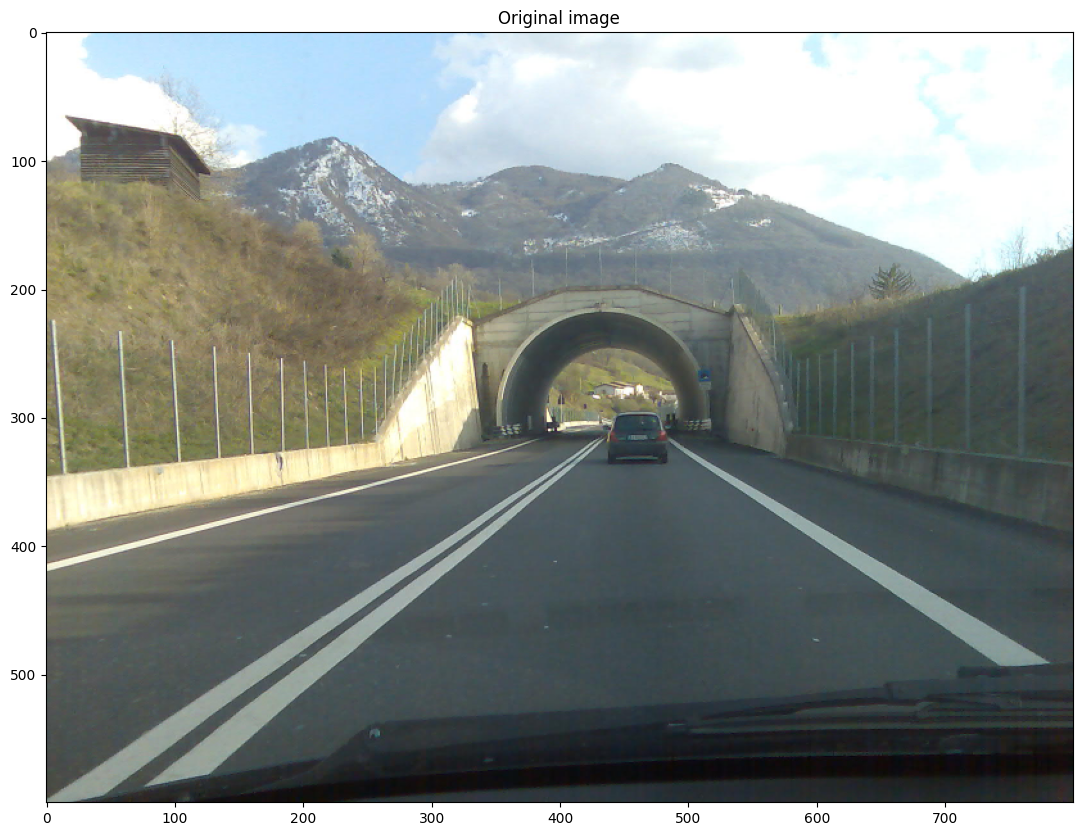

In [4]:
img = cv2.imread('dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)
plt.title('Original image')

## Шаг 2: Перевод изображения в оттенки серого

In [ ]:
# Перевод изображения в оттенки серого
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

## Шаг 3: Построение карты границ с помощью детектора Кэнни

In [ ]:
# Построение карты границ
# Используем детектор Кэнни с порогами th_low = 100, th_high = 150
edges = cv2.Canny(gray, threshold1=100, threshold2=150)

# Нас интересует только дорога, поэтому убираем всё выше горизонта
edges[0:350] = 0

In [ ]:
# Визуализация результатов
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

## Шаг 4: Применение преобразования Хафа для параметризации линий

In [15]:
# Применяем преобразование Хафа для параметризации линий
# Разрешение смещения: 2 пикселя, разрешение угла: 2 градуса
# Порог аккумулятора: 190
lines = cv2.HoughLines(edges, rho=2, theta=2 * np.pi / 180, threshold=190)
# Убираем лишнее измерение
lines = lines[:, 0, :]

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

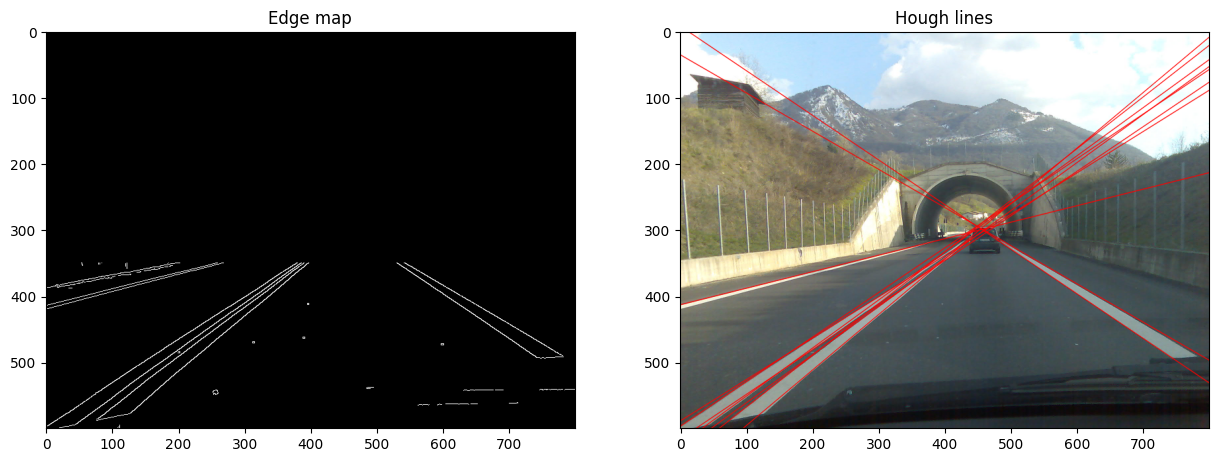

In [16]:
# Отрисовка найденных линий Хафа
result = np.copy(img)

for line in lines:
    rho = line[0]
    theta = line[1]

    a = math.cos(theta)
    b = math.sin(theta)

    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

Карта границ выглядит хорошо, но линии Хафа слишком зашумлены. Давайте очистим их, удалив все линии, которые не могут быть линиями разметки. Другими словами, все приблизительно горизонтальные линии должны быть удалены. Напомним, что горизонтальные линии соответствуют theta = 90 градусов.

## Шаг 5: Фильтрация приблизительно горизонтальных линий (+/- 20 градусов)

In [17]:
# Фильтрация всех приблизительно горизонтальных линий (+/- 20 градусов).
filtered_lines = []
for line in lines:
    # Извлекаем theta для текущей линии (Хаф работает в радианах)
    theta = line[1]
    # Оставляем линию, если она НЕ горизонтальная
    # Горизонталь: theta ~ pi/2 (90 град.), исключаем диапазон [70 град., 110 град.]
    if theta < np.radians(70) or theta > np.radians(110):
        filtered_lines.append(line)

filtered_lines = np.array(filtered_lines)

(<Axes: title={'center': 'Hough lines (filtered)'}>,
 Text(0.5, 1.0, 'Hough lines (filtered)'))

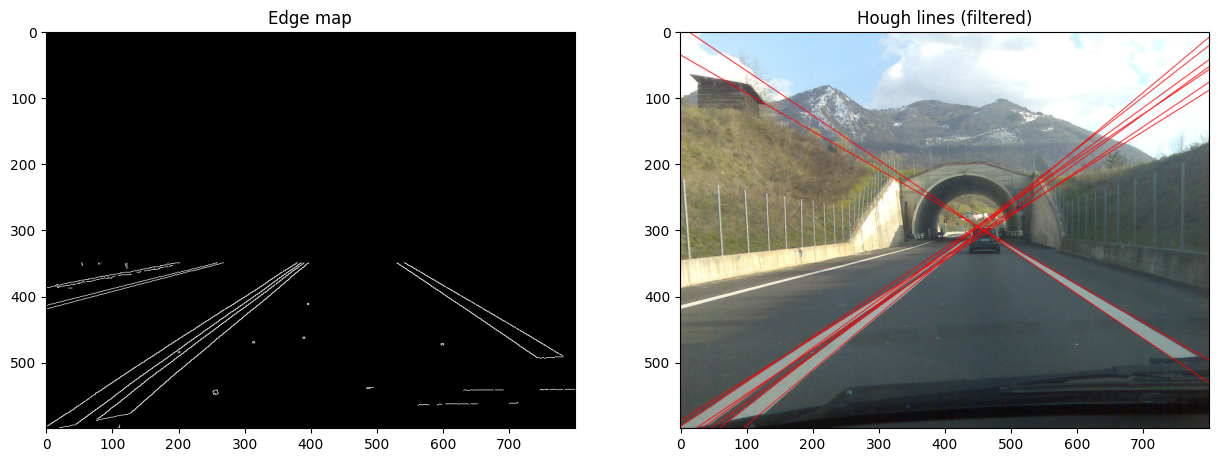

In [18]:
# Отрисовка отфильтрованных линий
result = np.copy(img)

for line in filtered_lines:
    rho = line[0]
    theta = line[1]

    a = math.cos(theta)
    b = math.sin(theta)

    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines (filtered)')

Результат теперь гораздо лучше, но мы всё ещё видим несколько очень похожих линий. Как от них избавиться?
* Применим кластеризацию K-means. Она найдёт кластеры из 6 линий, которые мы видим на изображении, и использует их средние значения.

## Шаг 6: Кластеризация K-means для уточнения найденных линий

In [20]:
# Применяем кластеризацию K-means для уточнения найденных линий.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

array([[497.        ,   0.99483764],
       [ 31.        ,   2.0943952 ],
       [ -7.        ,   2.1642082 ],
       [511.        ,   0.94247776],
       [521.        ,   0.87266463],
       [505.        ,   0.94247776]], dtype=float32)

(<Axes: title={'center': 'Hough lines (k-means refined)'}>,
 Text(0.5, 1.0, 'Hough lines (k-means refined)'))

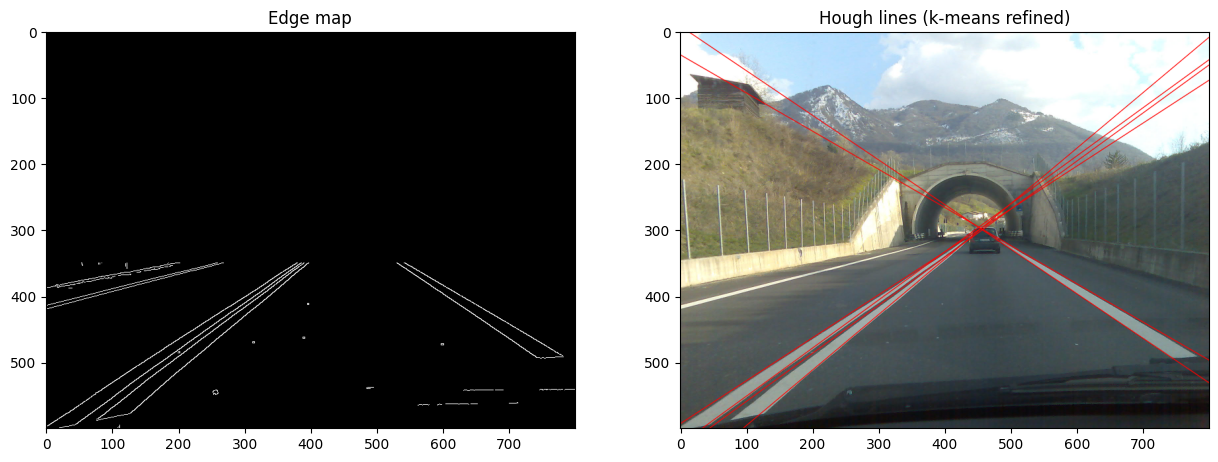

In [21]:
# Отрисовка итоговых уточнённых линий
result = np.copy(img)

for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]

    a = math.cos(theta)
    b = math.sin(theta)

    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines (k-means refined)')

## Ответы на вопросы

**Замечаете ли вы что-то странное в итоговом результате?**

Да. Не все 6 линий — это разметка: часть попала на стену/обочину и край тоннеля. И некоторые линии чуть смещены, потому что K-means “усредняет” близкие линии.

**Считаете ли вы, что разрешение преобразования Хафа важно для получения хорошего результата? Почему?**

Да, важно. Слишком крупное разрешение — линии сливаются, слишком мелкое — голоса в аккумуляторе “размазываются” и линия может не набрать порог. 2 пикселя и 2° — нормальный компромисс.

**Считаете ли вы, что порог аккумулятора преобразования Хафа важен для получения хорошего результата? Почему?**

Да, важно. Маленький порог даёт много ложных линий, большой — можно пропустить настоящую разметку. Порог 190 выглядит удачным: находит основные линии без лишнего шума.


